# Marvel Data

In [1]:
import json
from collections import defaultdict, Counter
from csv import DictReader
from itertools import cycle, islice
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
%matplotlib inline

In [2]:
data_dir = Path("data")
output_dir = Path("img")
Path.mkdir(output_dir, exist_ok=True)

In [3]:
def load_data(endpoint):
    endpoint_pages = sorted(data_dir.glob(f"{endpoint}_*.json"))
    
    endpoints = defaultdict(dict)
    for page in endpoint_pages:
        for char in json.loads(page.read_text()):
            endpoints[char["id"]] = char
    return endpoints

In [4]:
def parse_data(endpoint_data):
    parsed_data = {}
    for char in endpoint_data:
        _id = endpoint_data[char]["id"]
        name = endpoint_data[char]["name"]
        comics = endpoint_data[char]["comics"].get("available", 0)
        series = endpoint_data[char]["series"].get("available", 0)
        stories = endpoint_data[char]["stories"].get("available", 0)
        events = endpoint_data[char]["events"].get("available", 0)
        character = {
            "comics": comics,
            "series": series,
            "stories": stories,
            "events": events,
        }
        parsed_data[name] = character
    return parsed_data

In [5]:
def count_roles(data, roles):
    sorted_data = defaultdict(dict)
    for creator in sorted(data):
        sorted_data[creator] = Counter(data[creator])
    
    csv_str = ""
    for creator, counter in sorted_data.items():
        csv_str += f"{creator}"
        for role in roles:
            csv_str += f",{counter.get(role, 0)}"
        csv_str += "\n"
    return [row.split(",") for row in csv_str.splitlines()]

In [6]:
def create_dataframe():
    _data = load_data("characters")
    data = parse_data(_data)
    return pd.DataFrame(data=data, dtype=np.int8).T

In [7]:
def popularity(df, category, count=5):
    names = df.nlargest(count, category, keep="last").loc[:, category].index
    values = df.nlargest(count, category, keep="last").loc[:, category].values
    data = {category: list(values)}
    index = list(names)
    dataframe = pd.DataFrame(data=data)
    dataframe.index = index
    ax = dataframe.plot.barh(
        rot=15,
        figsize=(12,8),
        color=[plt.cm.Paired(np.arange(len(df)))],
        alpha=0.8,
        legend=False,
    )
    ax.set_title(f"Characters in the most {category}", fontsize=20)
    ax.set_xlabel(category.title(), fontsize=12)
    ax.grid(False)
    ax.set_facecolor("white")
    # https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart#28931750
    rects = ax.patches
    for rect in rects:
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2
        ha = "left"
        space = -25
        
        if x_value < 0:
            space *= -1
            ha = "right"
        
        plt.annotate(
            x_value,
            (x_value, y_value),
            xytext=(space, 0),
            textcoords="offset points",
            va="center",
            ha="left",
            color="white",
            fontsize=12,
        )
    plt.tight_layout()
    plt.show(block=True)
    fig = ax.get_figure()
    fig.savefig(f"{output_dir}/{category}.png")

In [8]:
df = create_dataframe()

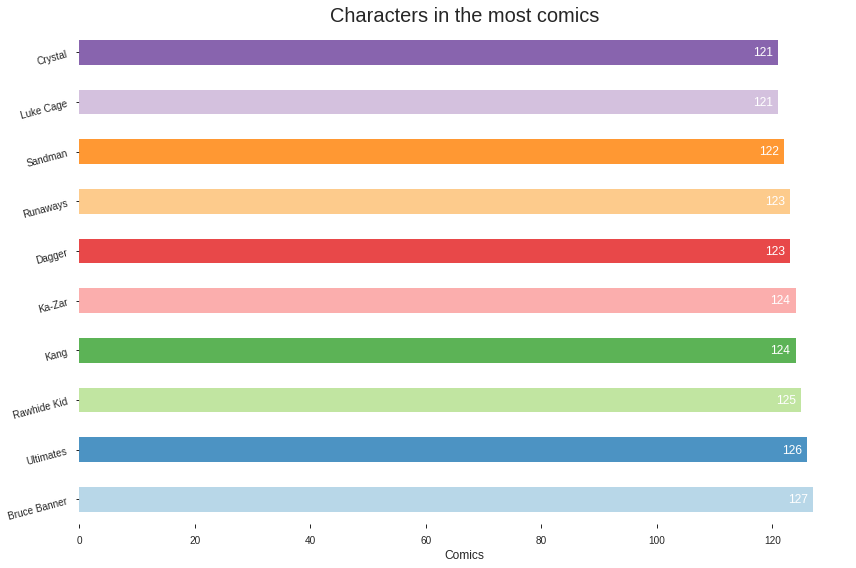

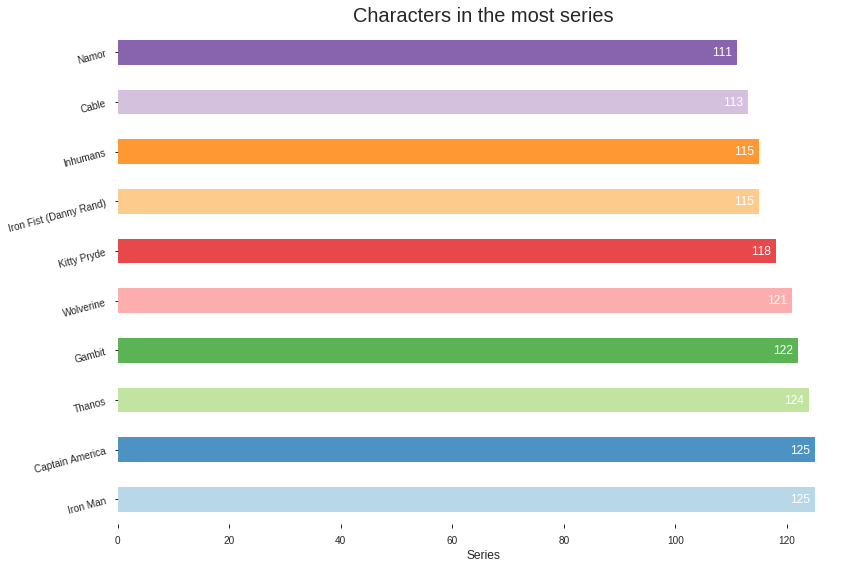

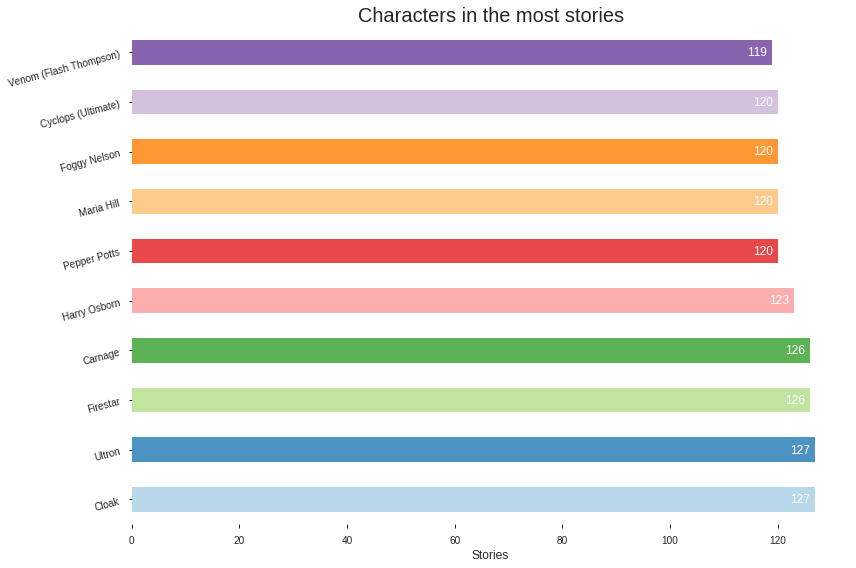

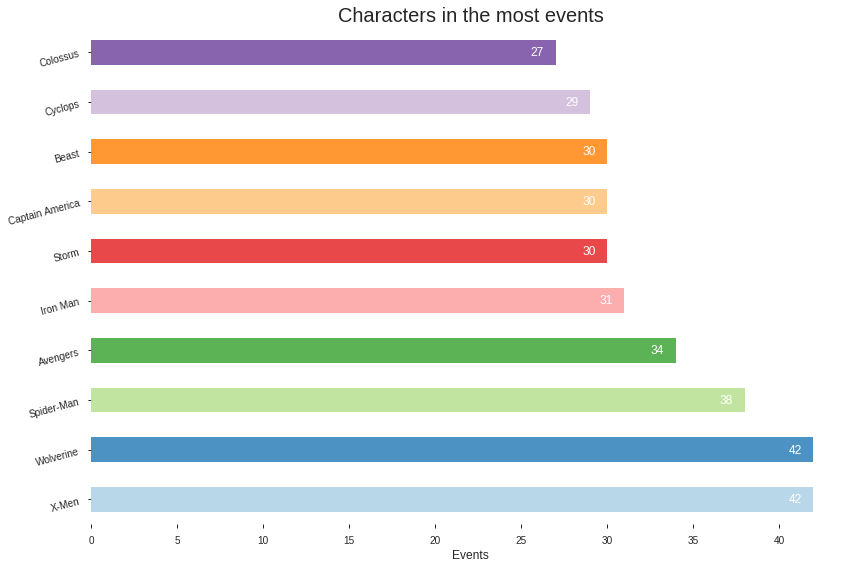

In [9]:
topics = "comics series stories events".split()
for category in topics:
    popularity(df, category, 10)

In [10]:
# df.profile_report()